<a href="https://colab.research.google.com/github/VectorInstitute/Causal_Inference_Laboratory/blob/main/notebooks/Hands_On_Session_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Hands-on Session #2

---

**Problem:** To estimate the impact of gender on admission result using Berkeley dataset

---

### Berkeley Dataset
**(Berkeley Admission)**: Students apply for university admission, and choose specific departments (sciences or arts & humanities) to which they wish to join. For the purpose of discrimination monitoring, gender is also recorded.
Here:
- Y represents the admission result(Y = 0 for not admitted, Y = 1 for admitted). 
- D represents the department (D = 0 for sciences, D = 1 for arts & humanities).
- X represents the gender (X = 0 for male, X = 1 for female).

---

Let's start

Load requirements

In [ ]:
!git clone https://github.com/VectorInstitute/Causal_Inference_Laboratory.git
%cd Causal_Inference_Laboratory
!pip install flaml
!pip install tensorflow_addons
!pip install keras-tuner
!pip install econml
!pip install xgboost==1.3.3

In [4]:
import numpy as np
from IPython.display import Image
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from fairness_analysis import load_data
from fairness.fc_helpers import msd_two
import utils.preprocessing as helper
import utils.metrics as metrics
from utils.evaluation import *
from utils.estimators import *

import warnings
warnings.filterwarnings('ignore')
seed = 0

# Data

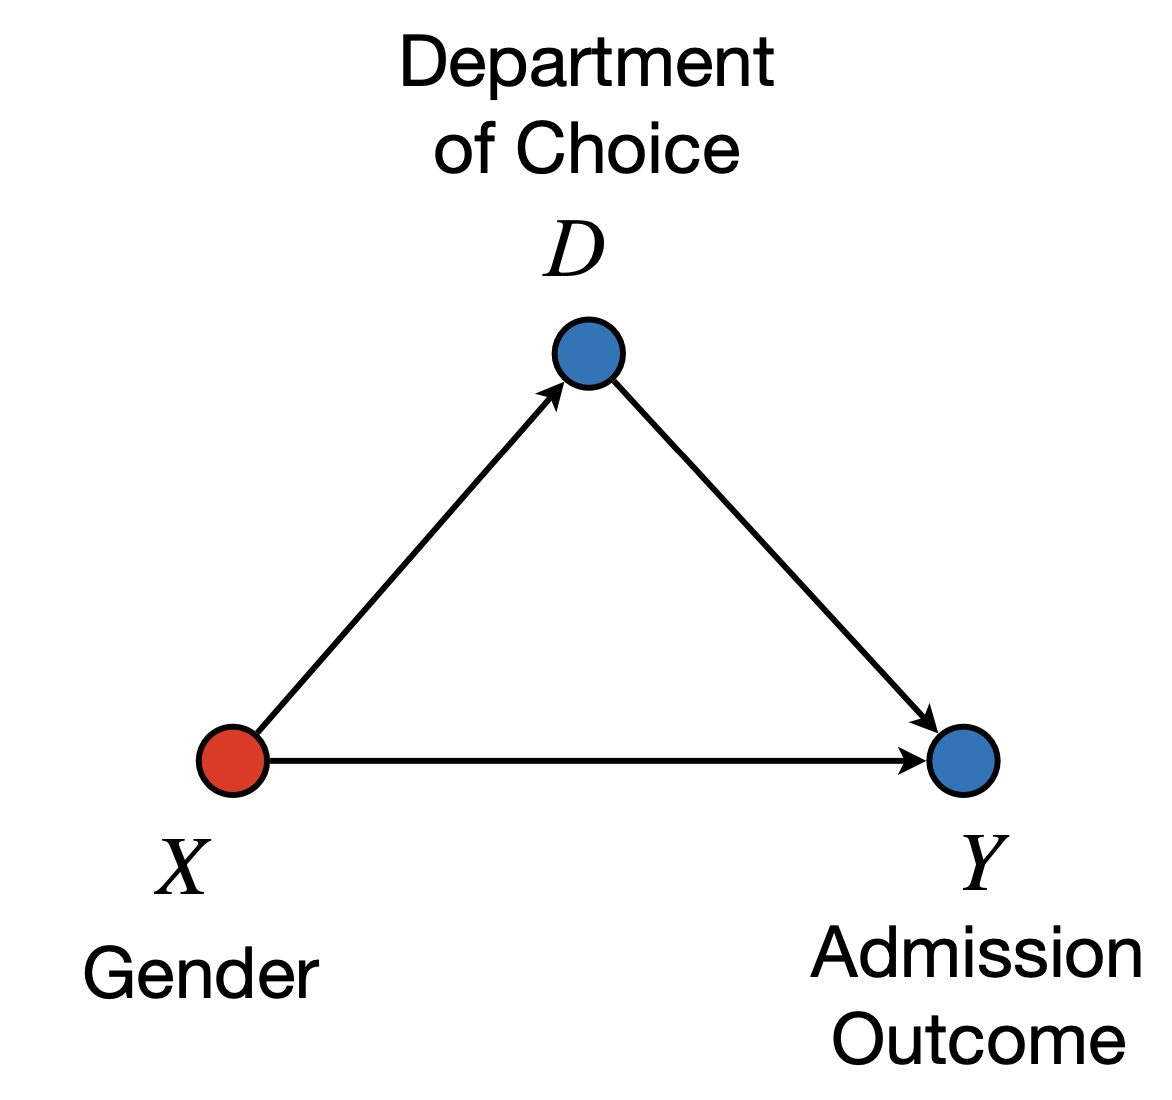

In [ ]:
Image('notebook_images/berkeley_graph.png', height=300)

In [ ]:
data_addr = "data/CFA/berkeley_numeric.csv"
data = load_data(data_addr)
    
data_header = list(pd.read_csv(data_addr).columns.values)[1:]
for i in range(len(data_header)):
  print("Column", i, ": ", data_header[i])

Column 0 :  admit
Column 1 :  gender
Column 2 :  dept


# Analyzing Data

In an initial analysis, a data scientist observed female applicants are 14% less likely of being accepted to the university than their male counterparts! TV=14%

By running the cell below, you can measure the total variation yourself.

In [ ]:
num_obs = len(data)
x0 = 1 #male
x1 = 0 #female
X = [1] #column ids of the protected attributes
Y = [0] #column ids of the outcome
idx = np.array([i for i in range(num_obs)])
id0 = idx[(data[:, X][idx] == [x0])[:, 0]]
id1 = idx[(data[:, X][idx] == [x1])[:, 0]]
y = data[:, Y]
tv = msd_two(y, id1, -y, id0)
print(tv)

[0.14164543]


We don't know that %14 total variation is because there is bias towards gender, or it is coming from the department choice. Let's solve it through causal inference analysis

## Part 1

In this section, you are asked to build any causal estimator of your choosing. You can refer to the demos and tutorial content for reference implementations.

In [16]:
def train_and_estimate_xxxLearner(x, t, yf, x_test=None):
    """
    Training using Random Forest (RF). For binary t, each t
    corresponds to one model.
    :param x: covariates
    :param t: treatment
    :param yf: factual outcomes
    :param x_test: out-of-sample covariates
    :return:
    """

    ### COMPLETE THIS CODE
    
    return y0_in, y1_in, ate_in, y0_out, y1_out, ate_out

### COMPLETE THIS CODE
# Enter the name of the estimator you chose to implement here
estimator_name = ...

Run this code to load the reformatted data from the .npz format into numpy arrays. Then, the estimator you created above is trained with this data and the results are saved.

In [17]:
datasets_folder_CFA = "data/CFA/"
x_all, t_all, yf_all = helper.load_berkeley_observational(
    datasets_folder_CFA
)
x_test_all, t_test_all, yf_test_all = helper.load_berkeley_out_of_sample(
    datasets_folder_CFA
)

x, t, yf = x_all[:, :, 0], t_all[:, 0], yf_all[:, 0]
x_test = x_test_all[:, :, 0]
y0_in, y1_in, ate_in, y0_out, y1_out, ate_out = train_and_estimate_xxxLearner(x, t, yf, x_test)

## Part 2

In this section, you are asked to evaluate your causal estimators. We will break down this process into 3 steps:

### Step 1

Processing the data to include/stack all realizations & split the training data into into train/validation sets.

In [18]:
# step #1
dataset_name = "berkeley"
x_all, t_all, yf_all = helper.load_berkeley_observational(
    datasets_folder_CFA
)
x_test_all, t_test_all, yf_test_all = helper.load_berkeley_out_of_sample(
    datasets_folder_CFA
)
mu0_in, mu1_in, mu0_out, mu1_out = None, None, None, None
ate_in_gt, ate_out_gt = None, None

# process in sample data
data_size_in = x_all.shape[0]
num_realizations_in = 1
if len(x_all.shape) == 3:
    num_realizations_in = x_all.shape[2]
    new_x_all = np.zeros((data_size_in * num_realizations_in, x_all.shape[1]))
    for i in range(num_realizations_in):
        new_x_all[i * data_size_in : (i + 1) * data_size_in, :] = x_all[:, :, i]
    x_all = new_x_all


# squeeze all eval data
x_all = np.reshape(x_all, (data_size_in*num_realizations_in, x_all.shape[1]))
t_all = np.reshape(t_all, (data_size_in * num_realizations_in), order='F')
yf_all = np.reshape(yf_all, (data_size_in * num_realizations_in), order='F')

indices_all = np.arange(x_all.shape[0])

x_train, x_eval_orig, t_train, t_eval_orig, yf_train, yf_eval_orig, indices_train, indices_eval = train_test_split(
    x_all, t_all, yf_all, indices_all, test_size=0.2, random_state=seed
    )

# process out of sample data
data_size_out = x_test_all.shape[0]
num_realizations_out = 1
if len(x_test_all.shape) == 3:
    num_realizations_out = x_test_all.shape[2]
    new_x_test_all = np.zeros((data_size_out * num_realizations_out, x_test_all.shape[1]))
    for i in range(num_realizations_out):
        new_x_test_all[i * data_size_out : (i + 1) * data_size_out, :] = x_test_all[:, :, i]
    x_test_all = new_x_test_all

# squeeze all test data
x_test_all = np.reshape(x_test_all, (data_size_out*num_realizations_out, x_test_all.shape[1]))
t_test_all = np.reshape(t_test_all, (data_size_out * num_realizations_out), order='F')
yf_test_all = np.reshape(yf_test_all, (data_size_out * num_realizations_out), order='F')

### Step 2

Load the Nuisance Models for propensity scoring, as well as the S-Learner, T-learner, and R-score models. Run inference on them for the evaluation and test sets.


In [19]:
nuisance_stats_dir= './/models//berkeley//'

### COMPLETE THIS CODE
# Load Nuisance Models for _eval and _test data for propensity score, s learner, etc.
prop_prob_in, prop_score_in = ...
outcome_s_pred_in = ...
outcome_t_pred_in = ...
outcome_r_pred_in = ...

prop_prob_out, prop_score_out = ...
outcome_s_pred_out = ...
outcome_t_pred_out = ...
outcome_r_pred_out = ...
###

results_in = {}
results_out = {}

# process in sample data
ite_estimate_in = y1_in.reshape((-1, 1), order='F') - y0_in.reshape((-1, 1), order='F')
ite_estimate_eval_in = ite_estimate_in[indices_eval]

# process out of sample data
ite_estimate_out = y1_out.reshape((-1, 1), order='F') - y0_out.reshape((-1, 1), order='F')
ite_estimate_eval_out = ite_estimate_out

### Step 3

Calculate the evaluation metrics for the xxxLearner causal estimator using the Nuisance Models and the estimation results. 

Here is an example for an arbitrary metric `metric_xxx`:

```
metric = "metric_xxx"
results_in[metric] = metrics.calculate_xxx(
    ite_estimate_eval_in, x_eval, t_eval, yf_eval, dataset_name=dataset_name, prop_score=prop_score_in
)
results_out[metric] = metrics.calculate_xxx(
    ite_estimate_eval_out, x_eval_out, t_eval_out, yf_eval_out, dataset_name=dataset_name, prop_score=prop_score_out
)
metrics_set.append(metric)
```

In [26]:
metrics_set = []

#############################################################
####  Add as many evaluation metrics as you'd like here. ####
#############################################################


Use the code below to print the results for all the metrics in a table.

In [ ]:
def print_table(header, data):
    table_width = 79
    header_line = f'| {header.center(table_width - 4)} |'
    separator_line = f'+{"-" * (table_width - 2)}+'

    print(separator_line)
    print(header_line)
    print(separator_line)

    for row in data:
        row_line = f'| {row[0].ljust(30)} | {row[1].ljust(15)} | {str(row[2]).ljust(24)} |'
        print(row_line)

    print(separator_line)

# In-sample results
header_in = f' In-sample results '
data_in = [[metric, estimator_name, results_in[metric]] for metric in metrics_set]

# Out-of-sample results
header_out = f' Out-of-sample results '
data_out = [[metric, estimator_name, results_out[metric]] for metric in metrics_set]

print_table(header_in, data_in)
print_table(header_out, data_out)